In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

from sklearn.cluster import KMeans

# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589215 entries, 0 to 589214
Data columns (total 33 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   start_date                              589215 non-null  object 
 1   end_date                                589215 non-null  object 
 2   start_time_hourly                       589215 non-null  int64  
 3   end_time_hourly                         589215 non-null  int64  
 4   start_station_id                        589215 non-null  int64  
 5   end_station_id                          589215 non-null  int64  
 6   bike_id                                 589215 non-null  int64  
 7   start_latitude                          589215 non-null  float64
 8   start_longitude                         589215 non-null  float64
 9   end_latitude                            589215 non-null  float64
 10  end_longitude                           5892

#### Adding feature `tripduration_min`

In [2]:
dfPhiladelphia['tripduration_min'] = dfPhiladelphia.apply(lambda row: round(row["tripduration_sec"]/60,0), axis=1)

#### Taking the features which are relevant for clustering

In [3]:
dfPhiladelphia_clu = dfPhiladelphia[['start_time_hourly','tripduration_min',"distance (km)"]]
dfPhiladelphia_clu

,start_time_hourly,tripduration_min,distance (km)
0,0,8.0,1.485913
1,0,7.0,1.376549
2,1,13.0,2.133107
3,1,9.0,1.367935
4,1,12.0,2.044202
...,...,...,...
589210,23,13.0,1.471507
589211,23,12.0,1.471507
589212,23,4.0,0.587019
589213,0,7.0,1.575003


In [4]:
# taking the quantiles of tripduration_min and distance (km) (accurating the cluster results)

dfPhiladelphia_clu = dfPhiladelphia_clu[(dfPhiladelphia_clu['distance (km)'] < dfPhiladelphia_clu['distance (km)'].quantile(0.99))]
dfPhiladelphia_clu = dfPhiladelphia_clu[(dfPhiladelphia_clu['tripduration_min'] < dfPhiladelphia_clu['tripduration_min'].quantile(0.95))]

In [5]:
dfPhiladelphia_clu

,start_time_hourly,tripduration_min,distance (km)
0,0,8.0,1.485913
1,0,7.0,1.376549
2,1,13.0,2.133107
3,1,9.0,1.367935
4,1,12.0,2.044202
...,...,...,...
589210,23,13.0,1.471507
589211,23,12.0,1.471507
589212,23,4.0,0.587019
589213,0,7.0,1.575003


In [6]:
# normalize the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dfPhiladelphia_clu)
dfPhiladelphia_clu_scaled = scaler.transform(dfPhiladelphia_clu)
X_scaled_df = pd.DataFrame(dfPhiladelphia_clu_scaled, columns=dfPhiladelphia_clu.columns, 
                           index=dfPhiladelphia_clu.index)
X_scaled_df.head()

,start_time_hourly,tripduration_min,distance (km)
0,-2.810701,-0.581838,-0.234506
1,-2.810701,-0.766191,-0.373350
2,-2.610537,0.339926,0.587147
3,-2.610537,-0.397485,-0.384286
4,-2.610537,0.155573,0.474276


---

## Clustering

### 1) Clustering types of bike users

#### Looking for the numbers of clusters

Using the elbow method to pick the correct number of clusters to work with.

In [7]:
clusters = []
losses = []

for k in range(20):
    model = KMeans(n_clusters=k+1,n_init=1)
    model.fit(X_scaled_df)
    clusters.append(k+1)
    losses.append(model.inertia_)

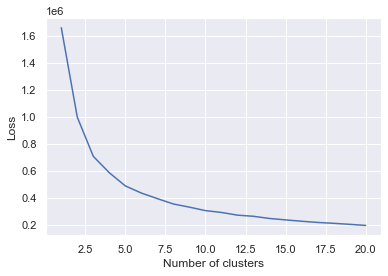

In [8]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

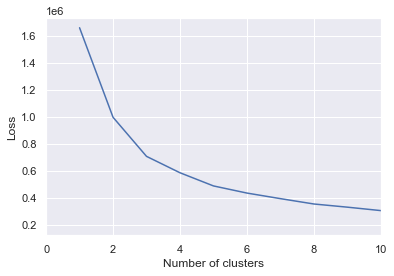

In [9]:
# taking a deeper look 

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
plt.show()

By using the elbow method we see, that the, so called 'elbow' lies at three. But taking five clusters would be also meaningful and should fit. That is what we are doing now.

In [10]:
kmean = KMeans(n_clusters=5,init='k-means++', random_state=42)

In [11]:
kmean.fit(X_scaled_df)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [12]:
Clusters = kmean.predict(X_scaled_df)

In [13]:
# creating a column for the calculated clusters

dfPhiladelphia_clu.loc[:, 'cluster_number'] = Clusters
dfPhiladelphia_clu

,start_time_hourly,tripduration_min,distance (km),cluster_number
0,0,8.0,1.485913,1
1,0,7.0,1.376549,1
2,1,13.0,2.133107,4
3,1,9.0,1.367935,1
4,1,12.0,2.044202,4
...,...,...,...,...
589210,23,13.0,1.471507,2
589211,23,12.0,1.471507,2
589212,23,4.0,0.587019,0
589213,0,7.0,1.575003,1


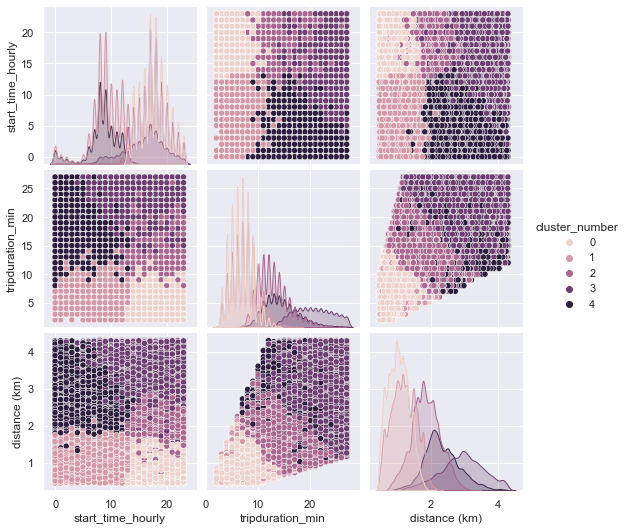

In [14]:
sns.pairplot(data=dfPhiladelphia_clu, hue = 'cluster_number')

In [15]:
def get_quantiles_of_clusters(n_cluster):
    for cluster in range(0,n_cluster):
        dfPhiladelphia_c0 = dfPhiladelphia_clu[dfPhiladelphia_clu['cluster_number']==cluster]
        print('cluster', cluster)
        print('0,25 - quantile')
        print(dfPhiladelphia_c0.quantile(q=0.25))
        print('0,75 - quantile')
        print(dfPhiladelphia_c0.quantile(q=0.75),'\n')

In [16]:
get_quantiles_of_clusters(5)

cluster 0
0,25 - quantile
start_time_hourly    16.000000
tripduration_min      5.000000
distance (km)         0.785054
cluster_number        0.000000
Name: 0.25, dtype: float64
0,75 - quantile
start_time_hourly    19.000000
tripduration_min      8.000000
distance (km)         1.241135
cluster_number        0.000000
Name: 0.75, dtype: float64 

cluster 1
0,25 - quantile
start_time_hourly    8.000000
tripduration_min     6.000000
distance (km)        0.907358
cluster_number       1.000000
Name: 0.25, dtype: float64
0,75 - quantile
start_time_hourly    11.000000
tripduration_min      9.000000
distance (km)         1.465597
cluster_number        1.000000
Name: 0.75, dtype: float64 

cluster 2
0,25 - quantile
start_time_hourly    16.000000
tripduration_min     11.000000
distance (km)         1.558621
cluster_number        2.000000
Name: 0.25, dtype: float64
0,75 - quantile
start_time_hourly    19.000000
tripduration_min     15.000000
distance (km)         2.125875
cluster_number        2.00

---

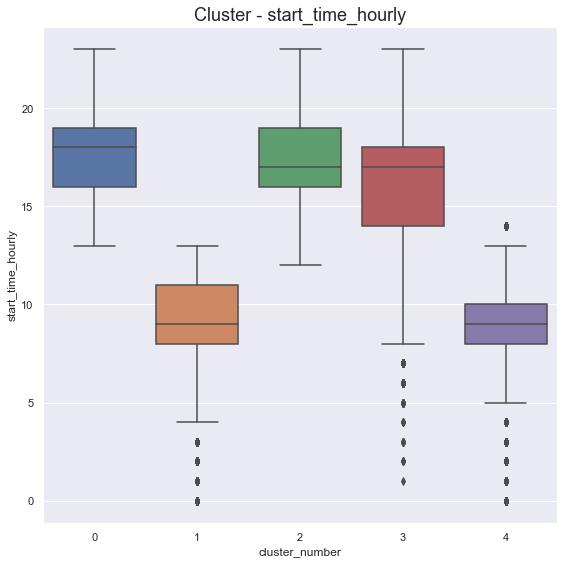

In [17]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["start_time_hourly"], x = dfPhiladelphia_clu['cluster_number']).set_title("Cluster - start_time_hourly").set_fontsize('18')
plt.tight_layout()

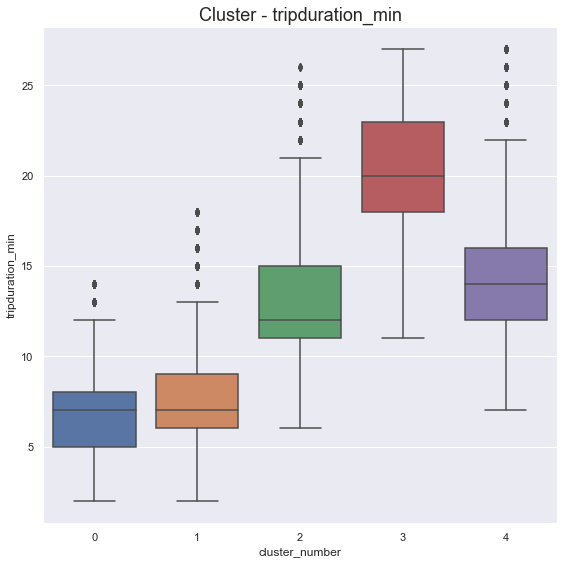

In [18]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["tripduration_min"], x = dfPhiladelphia_clu['cluster_number']).set_title("Cluster - tripduration_min").set_fontsize('18')
plt.tight_layout()

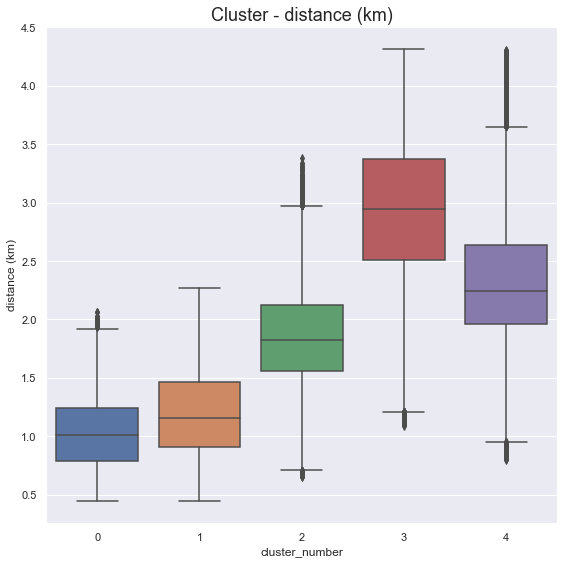

In [19]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["distance (km)"], x = dfPhiladelphia_clu['cluster_number']).set_title("Cluster - distance (km)").set_fontsize('18')
plt.tight_layout()

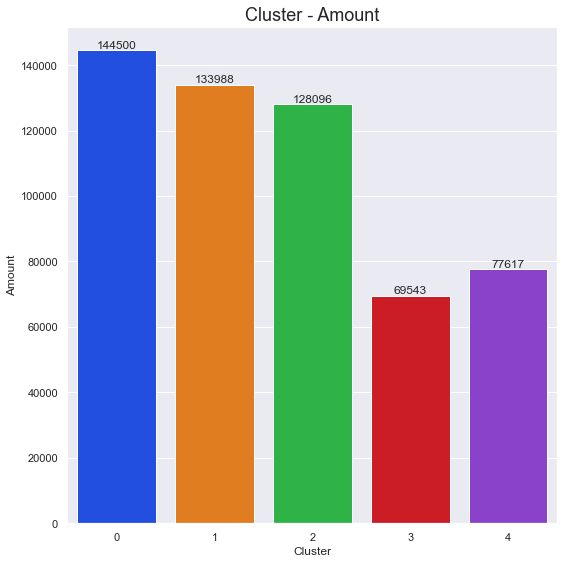

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = sns.countplot(x="cluster_number", data=dfPhiladelphia_clu, palette="bright")
ax.set_xlabel("Cluster")
ax.set_ylabel("Amount")
ax.set_title('Cluster - Amount',fontsize=18)
fig.tight_layout()

for container in ax.containers:
    ax.bar_label(container)

In [35]:
#d = {'clusters': [0, 1, 2, 3, 4], 
 #    'tripstart-hour': ['16-19', '8-11', '16-19', '14-18', '8-10'], 
  #   'tripduartion-minutes': ['5-8', '6-9', '11-15', '18-23', '12-16'],
   #  'tripdistance-km': ['0.8 - 1.2', '0.9 - 1.5', '1.5 - 2.1', '2.5 - 3.4', '2.0 - 2.6'],
    #'trpis (#)':['144500', '133988', '128096', '69543', '77617'],
     #'trips (in %)':['26%','24%', '23%', '13%', '14%']}
#df = pd.DataFrame(data=d)
#df

In [36]:
#print(df.to_markdown())#tablefmt="grid"))

### Labeling the clusters

What types of clusters we got:

|   clusters | tripstart-hour   | tripduartion-minutes   | tripdistance-km   |   trpis (#) | trips (in %)   |
|-----------:|:-----------------|:-----------------------|:------------------|------------:|:---------------|
|          0 | 16-19            | 5-8                    | 0.8 - 1.2         |      144500 | 26%            |
|          1 | 8-11             | 6-9                    | 0.9 - 1.5         |      133988 | 24%            |
|          2 | 16-19            | 11-15                  | 1.5 - 2.1         |      128096 | 23%            |
|          3 | 14-18            | 18-23                  | 2.5 - 3.4         |       69543 | 13%            |
|          4 | 8-10             | 12-16                  | 2.0 - 2.6         |       77617 | 14%            |

**Cluster 0:**<br>
<br>
**Cluster 1:**<br>
<br>
**Cluster 2:**<br>
<br>
**Cluster 3:**<br>
<br>
**Cluster 4:**<br>

---

### 2) Clustering the locations 

Here we are looking for clusters of the locations based on their demand pattern

In [23]:
# creating the dataframe we need for the clustering

dfPhiladelphia_loc_cluster = dfPhiladelphia[['start_latitude',
                                             'start_longitude','numOfRentedBikesHourlyStationDependent']]

In [24]:
dfPhiladelphia_loc_cluster

,start_latitude,start_longitude,numOfRentedBikesHourlyStationDependent
0,39.94509,-75.14250,1
1,39.94733,-75.14403,1
2,39.97195,-75.13445,1
3,39.96716,-75.17001,1
4,39.95081,-75.16953,1
...,...,...,...
589210,39.95273,-75.15979,3
589211,39.95273,-75.15979,3
589212,39.94019,-75.16691,1
589213,39.94732,-75.15695,1


In [25]:
# grouping the locations and creating a column containing the number of bikes rented in the whole year (2019)

dfPhiladelphia_loc_cluster = dfPhiladelphia_loc_cluster.groupby(['start_latitude', 'start_longitude'], 
                                        as_index=False)['numOfRentedBikesHourlyStationDependent'].sum()
dfPhiladelphia_loc_cluster

,start_latitude,start_longitude,numOfRentedBikesHourlyStationDependent
0,39.889940,-75.176790,613
1,39.893070,-75.171677,135
2,39.896290,-75.175140,605
3,39.904710,-75.173400,3219
4,39.920830,-75.170330,5261
...,...,...,...
141,39.987170,-75.174770,347
142,39.987709,-75.180519,68
143,39.988370,-75.187010,628
144,39.991190,-75.179750,687


#### Looking for the numbers of clusters

Using the elbow method to pick the correct number of clusters to work with.

In [26]:
clusters = []
losses = []

for k in range(20):
    model = KMeans(n_clusters=k+1,n_init=1)
    model.fit(dfPhiladelphia_loc_cluster)
    clusters.append(k+1)
    losses.append(model.inertia_)

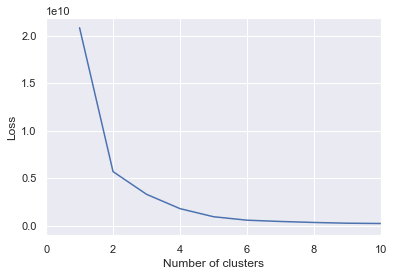

In [27]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
plt.show()

In [28]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    random_state=42
)

In [29]:
kmeans.fit(dfPhiladelphia_loc_cluster)
# save results
labels = kmeans.labels_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
dfPhiladelphia_loc_cluster['cluster'] = labels
# display the number of mamber each clustering
dfPhiladelphia_loc_cluster.reset_index(inplace=True, drop = True)

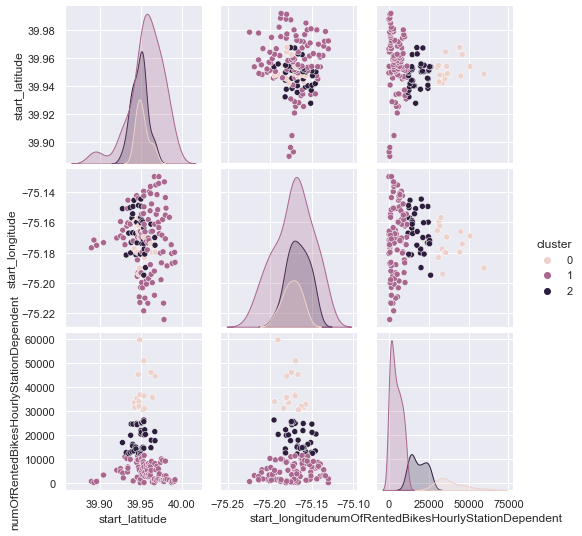

In [31]:
sns.pairplot(data=dfPhiladelphia_loc_cluster, hue = 'cluster')

**Creating a map to visualize the loaction clusters calculated above.**

In [32]:
import folium

colors = ['blue', 'orange', 'green', 'red', 'purple', 'darkred', \
     'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray' ]
    

cluster_color = colors[0:5]

lati = dfPhiladelphia_loc_cluster['start_latitude']
longi = dfPhiladelphia_loc_cluster['start_longitude']
cluster_for_color = dfPhiladelphia_loc_cluster['cluster']


map=folium.Map(location = [39.94509,-75.14250],tiles="Stamen Toner", zoom_start=12)

for i in range(len(dfPhiladelphia_loc_cluster)):
    folium.Circle([lati[i],longi[i]], fill = True, color = colors[cluster_for_color[i]], radius= 75).add_to(map)


map

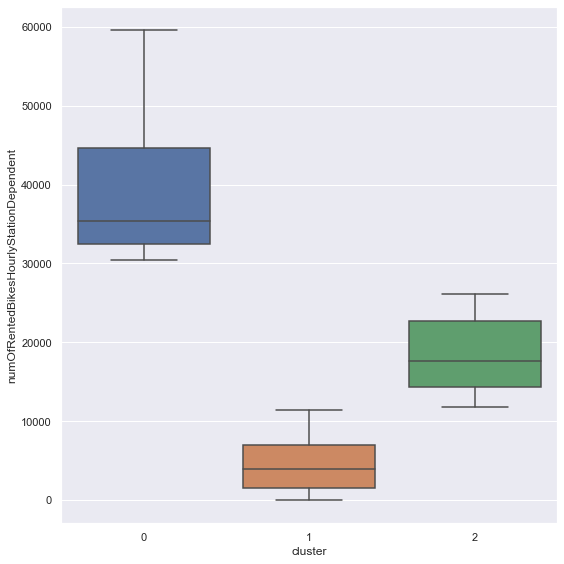

In [33]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_loc_cluster["numOfRentedBikesHourlyStationDependent"], 
            x = dfPhiladelphia_loc_cluster['cluster'])
plt.tight_layout()

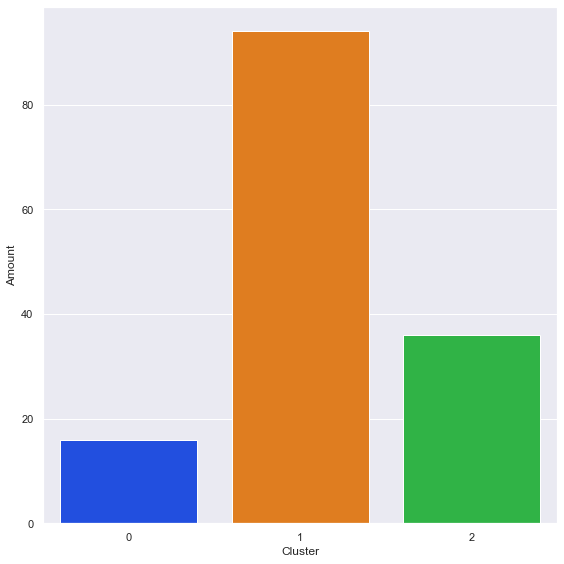

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = sns.countplot(x="cluster", data=dfPhiladelphia_loc_cluster, palette="bright")
ax.set_xlabel("Cluster")
ax.set_ylabel("Amount")
fig.tight_layout()

# 3. Cluster Analysis

We use a **Cluster Analysis** in order to identify clusters of 
 - *trip types* and/or
 - *customer types*
 
based on the bike rental demand patterns.

Additionally we are interested, whether we can *label these clusters* and *cluster the locations* based on their demand pattern.

## 3.1 Data Prep and Scaling

## 3.2 Principal Component Analysis (PCA)
- for dimensionality reduction

## 3.3 Clustering with Dendrogram